In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [2]:
base_dir = './data'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

train_G43_dir = os.path.join(train_dir, 'G43')  
train_S29_dir = os.path.join(train_dir, 'S29')  
train_M17_dir = os.path.join(train_dir, 'M17')  

validation_G43_dir = os.path.join(validation_dir, 'G43')
validation_S29_dir = os.path.join(validation_dir, 'S29') 
validation_M17_dir = os.path.join(validation_dir, 'M17') 

test_G43_dir = os.path.join(test_dir, 'G43')
test_S29_dir = os.path.join(test_dir, 'S29') 
test_M17_dir = os.path.join(test_dir, 'M17') 

In [3]:
num_G43_tr = len(os.listdir(train_G43_dir))
num_S29_tr = len(os.listdir(train_S29_dir))
num_M17_tr = len(os.listdir(train_M17_dir))

num_G43_val = len(os.listdir(validation_G43_dir))
num_S29_val = len(os.listdir(validation_S29_dir))
num_M17_val = len(os.listdir(validation_M17_dir))

total_train = num_G43_tr + num_S29_tr + num_M17_tr
total_val = num_G43_val + num_S29_val + num_M17_val

print('The dataset contains:')
print('\u2022 {:,} training images'.format(total_train))
print('\u2022 {:,} validation images'.format(total_val))

print('\nThe training set contains:')
print('\u2022 {:,} G43 images'.format(num_G43_tr))
print('\u2022 {:,} S29 images'.format(num_S29_tr))
print('\u2022 {:,} M17 images'.format(num_M17_tr))

print('\nThe validation set contains:')
print('\u2022 {:,} G43 images'.format(num_G43_val))
print('\u2022 {:,} S29 images'.format(num_S29_val))
print('\u2022 {:,} M17 images'.format(num_M17_val))

The dataset contains:
• 900 training images
• 150 validation images

The training set contains:
• 300 G43 images
• 300 S29 images
• 300 M17 images

The validation set contains:
• 50 G43 images
• 50 S29 images
• 50 M17 images


In [4]:
BATCH_SIZE = 64
IMG_HEIGHT  = 75
IMG_WIDTH = 50
image_gen = ImageDataGenerator(rescale=1./255)

one_image = image_gen.flow_from_directory(directory=train_dir,
                                          batch_size=1,
                                          shuffle=True,
                                          target_size=(IMG_HEIGHT,IMG_WIDTH),
                                          class_mode='binary')

#plt.imshow(one_image[0][0][0])
#plt.show()
one_image[0][0][0].shape

Found 900 images belonging to 3 classes.


(75, 50, 3)

In [5]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

Found 900 images belonging to 3 classes.


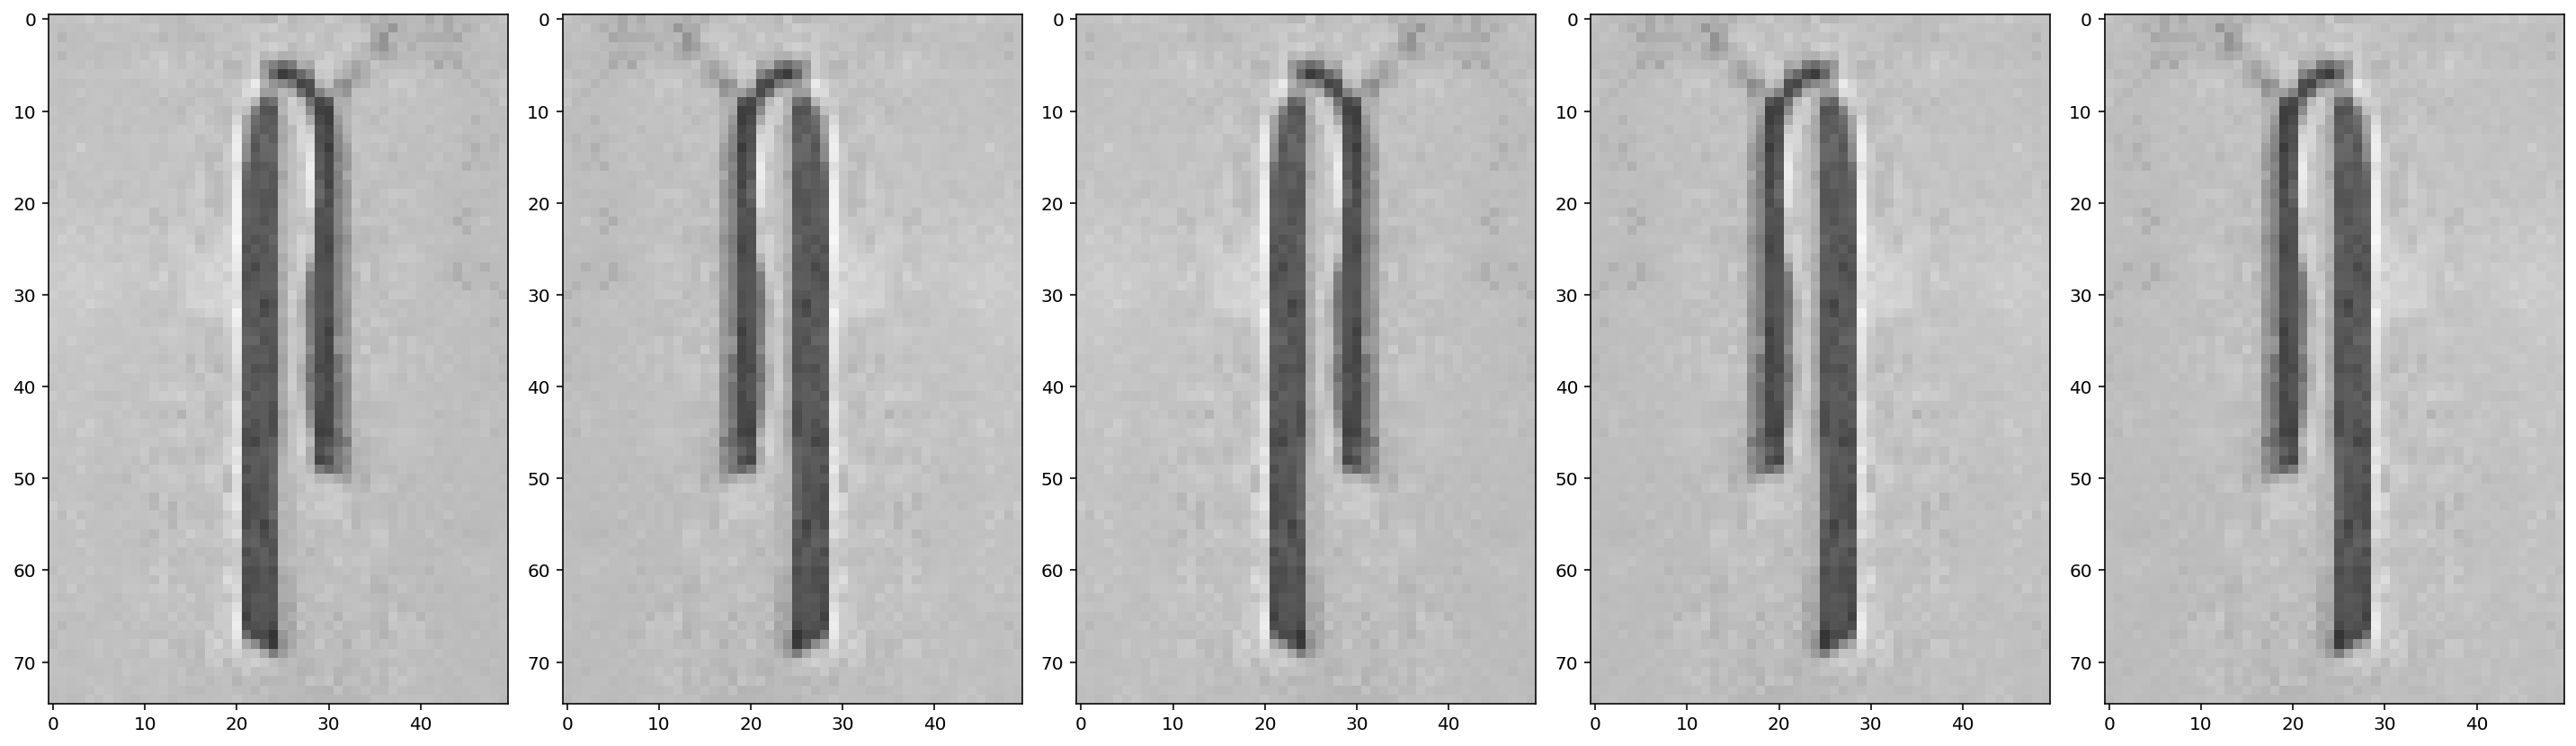

In [6]:
image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

train_data_gen = image_gen.flow_from_directory(directory=train_dir,
                                               batch_size=BATCH_SIZE,
                                               shuffle=True, 
                                               target_size=(IMG_HEIGHT,IMG_WIDTH),
                                               class_mode='binary')
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [7]:
image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(directory=validation_dir,
                                                 batch_size=23,
                                                 target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                 class_mode='binary')

Found 150 images belonging to 3 classes.


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(3, 'softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 75, 50, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 37, 25, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 37, 25, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 18, 12, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 18, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 6, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3456)              0

In [9]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

In [13]:
EPOCHS = 5

history = model.fit_generator(train_data_gen,
                              epochs=5,
                              validation_data=val_data_gen)

Epoch 1/5
    158/Unknown - 19s 122ms/step - loss: 0.0074 - sparse_categorical_accuracy: 0.9983

KeyboardInterrupt: 

In [ ]:
image_gen = ImageDataGenerator(rescale=1./255)

test_batch = image_gen.flow_from_directory(directory=test_dir,
                                          batch_size=4,
                                          shuffle=True,
                                          target_size=(75,50),
                                          class_mode='binary')
t, l = next(test_batch)
plt.imshow(t[1])
plt.title(l[1])
plt.show()                              

In [65]:
test_img = test_batch[0][0][1]
preds = model.predict(x = np.expand_dims(test_img, axis=0))
probs, class_idx = tf.math.top_k(preds, k=3)


fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
ax1.imshow(test_img, cmap = plt.cm.binary)
ax1.axis('off')
ax2.barh(np.arange(3), list(probs.numpy()[0]))
ax2.set_aspect(0.1)
ax2.set_yticks(np.arange(5))
ax2.set_yticklabels(list(class_idx.numpy()[0]));
ax2.set_title('Class Probability')
ax2.set_xlim(0, 1.1)
plt.tight_layout()

NameError: name 'model' is not defined

In [2]:
saved_keras_model_filepath = './{}.h5'.format('saved_model')

model.save(saved_keras_model_filepath)

NameError: name 'model' is not defined

In [171]:
import tensorflow_hub as hub
reloaded_model = tf.keras.models.load_model('saved_model.h5', custom_objects={'KerasLayer': hub.KerasLayer})

test_img = test_batch[0][0][3]
preds = reloaded_model.predict(x = np.expand_dims(test_img, axis=0))
probs, class_idx = tf.math.top_k(preds, k=3) #change to top 1 and get the exact result
class_names = ['G43', 'M17', 'S29']
classes=[]
for i in class_idx.numpy()[0]:
    classes.append(class_names[i])

fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
ax1.imshow(test_img, cmap = plt.cm.binary)
ax1.axis('off')
ax2.barh(np.arange(3), list(probs.numpy()[0]))
ax2.set_aspect(0.1)
ax2.set_yticks(np.arange(5))
ax2.set_yticklabels(classes);
ax2.set_title('Class Probability')
ax2.set_xlim(0, 1.1)
plt.tight_layout()

(1, 75, 50, 3)

In [5]:
import tensorflow_hub as hub
reloaded_model = tf.keras.models.load_model('saved_model.h5', custom_objects={'KerasLayer': hub.KerasLayer})
# load a png with 3 color channels
im = tf.io.read_file('./data/test/S29/cat.jpg')
#im=tf.io.decode_png(im, channels=3)
im = Image.open(im).convert('RGB')
im = np.asarray(im)
image = tf.image.resize(im, (75, 50))
image = tf.expand_dims(image, axis=0)
preds = reloaded_model.predict(image)
probs, class_idx = tf.math.top_k(preds, k=3) #change to top 1 and get the exact result
class_names = ['G43', 'M17', 'S29']
classes=[]
for i in class_idx.numpy()[0]:
    classes.append(class_names[i])

fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
ax1.imshow(test_img, cmap = plt.cm.binary)
ax1.axis('off')
ax2.barh(np.arange(3), list(probs.numpy()[0]))
ax2.set_aspect(0.1)
ax2.set_yticks(np.arange(5))
ax2.set_yticklabels(classes);
ax2.set_title('Class Probability')
ax2.set_xlim(0, 1.1)
plt.tight_layout()


ValueError: 'images' must have either 3 or 4 dimensions.